# Setup and Audio Visualization

In [1]:
import os
import shutil
import librosa
import scipy
import numpy as np
import tensorflow as tf
import IPython
import IPython.display as ipd 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
from keras import losses, models, optimizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.activations import relu, softmax
from keras.utils import Sequence, to_categorical
from keras.layers import (Layer, Input, Flatten, Dropout, BatchNormalization, Reshape,
                          Conv1D, Dense, MaxPool1D, LeakyReLU, ReLU, AveragePooling1D,
                          LSTM, SimpleRNNCell)
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)

Using TensorFlow backend.


In [3]:
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
    
print('Using device: ', device)

Using device:  /device:GPU:0


In [4]:
# CONSTS

DURATION = 4
RATIO = 4
SAMPLE_RATE = int(44100/RATIO)
SHAPE = SAMPLE_RATE*DURATION
NOISE_DIM = 500
MFCC = 40
TRAIN_DATA_PATH = "../../Datasets/freesound-audio-tagging/audio_train/"

pool_size = 4
encode_size = NOISE_DIM
dense_mid_size = 1024

In [5]:
def load_train_data(input_length=SHAPE, label = "Saxophone"):
    train = pd.read_csv("../../Datasets/freesound-audio-tagging/train.csv")
    if label != None:
        train_list = train.loc[train.label == label]
    else: 
        train_list = train
    cur_batch_size = len(train_list)
    train_fname_list = train_list.fname
    X = np.empty((cur_batch_size, input_length))
    for i, train_fname in enumerate(train_fname_list):
        file_path = TRAIN_DATA_PATH + train_fname
        
        # Read and Resample the audio
        data, _ = librosa.core.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        X[i,] = data
    print("Data Loaded...")
    return X
    
def normalization(X_train):
    mean = X_train.mean(keepdims=True)
    print("Mean: ", mean)
    std  = X_train.std(keepdims=True)
    print("Std: ", std)
    X_train = (X_train - mean) / std
    print("Data Normalized...")
    return X_train

trainData = load_train_data(input_length=SHAPE, label = "Saxophone")
trainData = normalization(trainData)

Data Loaded...
Mean:  [[0.00020651]]
Std:  [[0.19833671]]
Data Normalized...


In [6]:
train = pd.read_csv("../../Datasets/freesound-audio-tagging/train.csv")
test = pd.read_csv("../../Datasets/freesound-audio-tagging/sample_submission.csv")
print(train.label.unique())

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


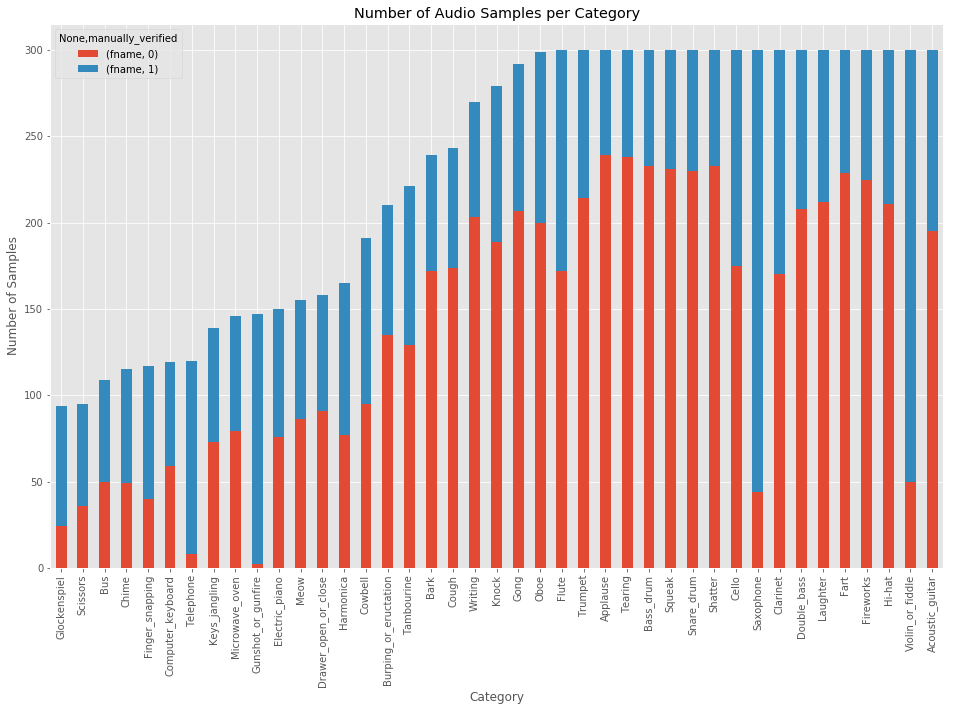

In [7]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

Total samples (frames) =  (154350,)
[ 4.1569961e-04 -6.4974086e-04  2.8693769e-04 ... -3.6912264e-05
 -5.2365900e-05 -1.1704843e-05]


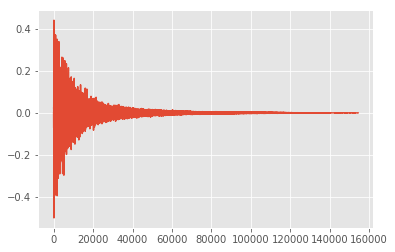

In [8]:
fname = "../../Datasets/freesound-audio-tagging/audio_train/" + "00044347.wav"   # Hi-hat
data, _ = librosa.core.load(fname, sr=SAMPLE_RATE, res_type='kaiser_fast')
print("Total samples (frames) = ", data.shape)
print(data)
IPython.display.display(ipd.Audio(filename=fname))
plt.plot(data, '-', )
plt.show()

Shape:  (40, 44)


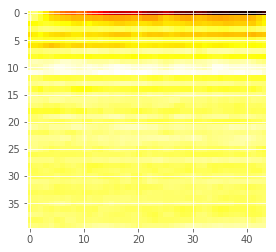

In [9]:
data = data[:2*SAMPLE_RATE]
mfcc = librosa.feature.mfcc(data, sr = SAMPLE_RATE, n_mfcc=40)
print("Shape: ", mfcc.shape)
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

# Using GANs for new sounds

### Discriminator

In [10]:
def discriminator():
    model = Sequential()
    model.add(Reshape((SHAPE, 1), input_shape=(SHAPE,)))
    model.add(Conv1D(3, int(0.20*SHAPE), padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(5, int(0.10*SHAPE), padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(7, int(0.02*SHAPE), padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Flatten())
    model.add(Dense(encode_size))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(1, activation='tanh'))
    return model

d = discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 44100, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35281, 3)          26463     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 35281, 3)          0         
_________________________________________________________________
average_pooling1d_1 (Average (None, 8820, 3)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8820, 3)           12        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8820, 3)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4411, 5)           66155     
__________

### Generator

In [11]:
def generator():
    model = Sequential()
    model.add(Dense(dense_mid_size, input_shape=(NOISE_DIM,)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Reshape((dense_mid_size,1)))
    
    model.add(Conv1D(dense_mid_size, 7, padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(int(0.02*SHAPE), 5, padding='same'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(int(0.08*SHAPE), 3, padding='same'))
    model.add(ReLU())
    model.add(Conv1D(int(SHAPE/15), 1, padding='same'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    model.add(Flatten())
    return model

g = generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              513024    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
reshape_2 (Reshape)          (None, 1024, 1)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1018, 1024)        8192      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 1018, 1024)        0         
_________________________________________________________________
average_pooling1d_4 (Average (None, 254, 1024)         0         
__________

### Auto Encoder

In [12]:
# AutoEncoder
def autoEncoder():
    model = Sequential()
    # Encoder
    model.add(Reshape((SHAPE, 1), input_shape=(SHAPE,)))
    model.add(Conv1D(3, int(0.20*SHAPE), padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(5, int(0.10*SHAPE), padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(7, int(0.02*SHAPE), padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    model.add(Flatten())
    #Code
    model.add(Dense(encode_size))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(dense_mid_size))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9))
    #Decoder
    model.add(Reshape((dense_mid_size, 1)))
    model.add(Conv1D(dense_mid_size, 7, padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(int(0.02*SHAPE), 5, padding='same'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(int(0.08*SHAPE), 3, padding='same'))
    model.add(ReLU())
    model.add(Conv1D(int(SHAPE/15), 1, padding='same'))
    model.add(ReLU())
    model.add(AveragePooling1D(pool_size))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    model.add(Flatten())
    return model

a = autoEncoder()
a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 44100, 1)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35281, 3)          26463     
_________________________________________________________________
re_lu_8 (ReLU)               (None, 35281, 3)          0         
_________________________________________________________________
average_pooling1d_7 (Average (None, 8820, 3)           0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 8820, 3)           12        
_________________________________________________________________
dropout_7 (Dropout)          (None, 8820, 3)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 4411, 5)           66155     
__________

In [ ]:
def run_autoEncoder(X, epochs=100,  save_internal=10, batch=32):
    A = autoEncoder()  
    A.compile(loss = 'mse', optimizer = Adam(lr = 0.001, decay = 0.5), metrics = ['accuracy'])
    for cnt in range(epochs):
        random_index = np.random.randint(0, len(X) - batch)
        legit_audios = X[random_index : int(random_index + batch)]
        loss = A.train_on_batch( legit_audios, legit_audios)
        if cnt % 10 == 0 : 
            print("Epoch: ",cnt, ", Loss: ", loss)
    return A

auto = run_autoEncoder(trainData, epochs=10, save_internal=1, batch=32)

Epoch:  0 , Loss:  [0.82284933, 0.0]


Original:


Result:


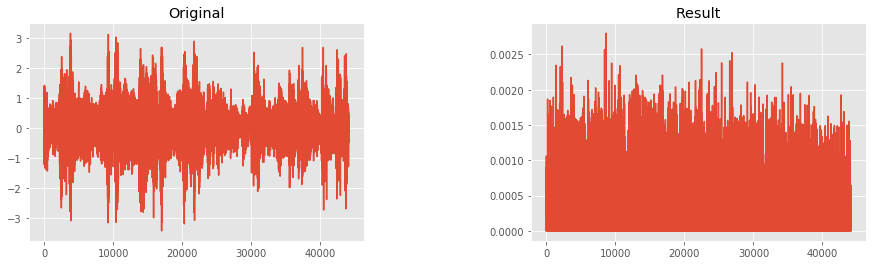

In [40]:
INDEX = 100

print("Original:")
IPython.display.display(ipd.Audio(data=X[INDEX], rate=SAMPLE_RATE))
result = auto.predict(X[INDEX].reshape((1,SHAPE))).flatten()
print("Result:")
IPython.display.display(ipd.Audio(data=result, rate=SAMPLE_RATE))

fig1     = plt.figure(figsize=(1, 2))
Original = fig1.add_subplot(1, 2, 1)
Result   = fig1.add_subplot(1, 2, 2)

Original.set_title('Original')
Result.set_title('Result')
Original.plot(X[INDEX], '-', )
Result.plot(result, '-', )

plt.gcf().set_size_inches(15, 4)
plt.subplots_adjust(wspace=0.5,hspace=0.3)
plt.show()

### Stacked Generator and Discriminator

In [13]:
def stacked_G_D(G, D, optimizer):
    model = Sequential()
    model.add(G)
    model.add(D)
    return model

s = stacked_G_D(g,d, Adam(lr = 0.0002, decay = 0.5))
s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 44100)             24775294  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 319056    
Total params: 25,094,350
Trainable params: 25,081,580
Non-trainable params: 12,770
_________________________________________________________________


### Audio GAN

In [14]:
class AudioGAN:
    def __init__(self, label = "Saxophone"):
        self.OPTIMIZER = Adam(lr = 0.0002, decay = 0.5)
        noise_gen = np.random.normal(0,1,(NOISE_DIM,))
        # Generate Models
        self.G = generator()
        self.D = discriminator()
        self.stacked_G_D = stacked_G_D(self.G, self.D, self.OPTIMIZER)
        # Compile Models
        self.G.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER, metrics = ['accuracy'])
        self.D.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER, metrics = ['accuracy'])
        self.stacked_G_D.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER,  metrics = ['accuracy'])
        self.X_train = normalization(load_train_data(SHAPE, label))
        self.D_loss_hist = []
        self.G_loss_hist = []
        
    def train(self, epochs = 20, batch = 32, save_interval = 2):
        for cnt in range(epochs):
            # train discriminator
            halfBatch = int(batch/2)
            random_index = np.random.randint(0, len(self.X_train) - halfBatch)
            legit_audios = self.X_train[random_index : int(random_index + halfBatch)]
            gen_noise = np.random.normal(0, 1, (halfBatch,NOISE_DIM))
            syntetic_audios = self.G.predict(gen_noise)
            x_combined_batch = np.concatenate((legit_audios, syntetic_audios))
            y_combined_batch = np.concatenate((np.ones((halfBatch, 1)), np.zeros((halfBatch, 1))))
            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)
            d_loss_mean = np.mean(d_loss)
            self.D_loss_hist.append(d_loss_mean)
            # train generator
            noise = np.random.normal(0, 1, (batch,NOISE_DIM))
            y_mislabled = np.ones((batch, 1))
            g_loss = self.stacked_G_D.train_on_batch(noise, y_mislabled)
            g_loss_mean = np.mean(g_loss)
            self.G_loss_hist.append(g_loss_mean)
            print ("epoch: %d" % (cnt)) 
            print ("Discriminator_loss: %f, Generator_loss: %f" % (d_loss_mean, g_loss_mean))
            if cnt % save_interval == 0 : 
                show_audios(G = self.G, step = cnt)

In [15]:
def show_audios(G, samples = 4, step=0):
    fig     = plt.figure(figsize=(1, samples))
    samplePlot = []
    noise = np.random.normal(0, 1, (samples,NOISE_DIM))
    audios = G.predict(noise)
    for i, audio in enumerate(audios):
        print("Audio Gen %d" % i)
        IPython.display.display(ipd.Audio(data=audio, rate=SAMPLE_RATE))
        samplePlot.append(fig.add_subplot(1, samples, i+1))
        samplePlot[i].plot(audio.flatten(), '-', )
    
    plt.gcf().set_size_inches(10, 15)
    plt.subplots_adjust(wspace=0.2,hspace=0.3)
    plt.show()

### Running GAN

In [16]:
myGan = AudioGAN(label = "Saxophone")

Data Loaded...
Mean:  [[0.00031762]]
Std:  [[0.1984336]]
Data Normalized...


epoch: 0
Discriminator_loss: 2.252866, Generator_loss: 4.576520
Audio Gen 0


Audio Gen 1


Audio Gen 2


Audio Gen 3


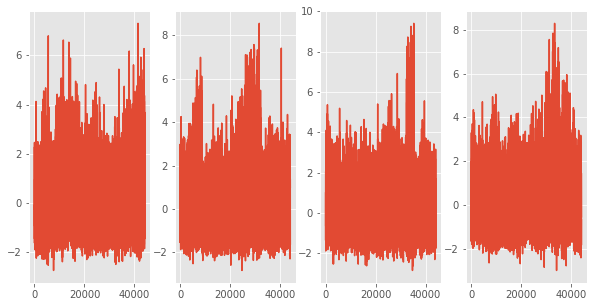

epoch: 1
Discriminator_loss: 2.716362, Generator_loss: 4.323730
epoch: 2
Discriminator_loss: 3.245224, Generator_loss: 3.873958
Audio Gen 0


Audio Gen 1


Audio Gen 2


Audio Gen 3


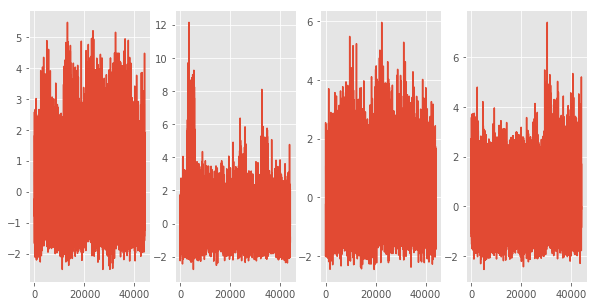

epoch: 3
Discriminator_loss: 2.650256, Generator_loss: 5.263759
epoch: 4
Discriminator_loss: 2.710052, Generator_loss: 4.364951
Audio Gen 0


Audio Gen 1


Audio Gen 2


Audio Gen 3


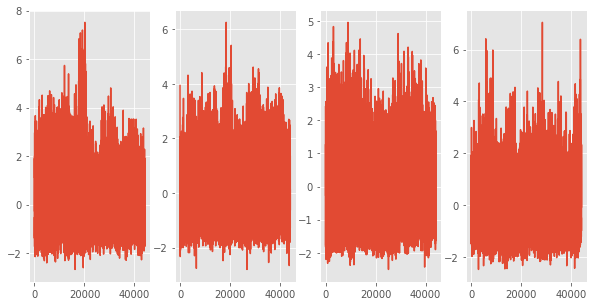

epoch: 5
Discriminator_loss: 2.968322, Generator_loss: 4.433423
epoch: 6
Discriminator_loss: 2.472802, Generator_loss: 3.888855
Audio Gen 0


Audio Gen 1


Audio Gen 2


Audio Gen 3


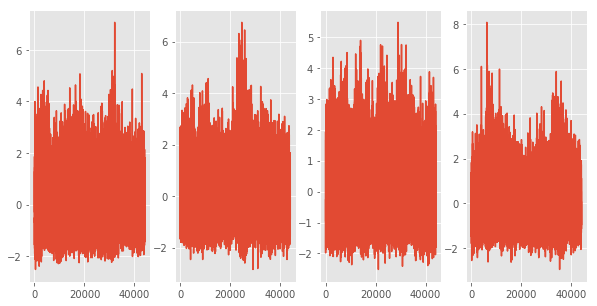

epoch: 7
Discriminator_loss: 1.916384, Generator_loss: 4.326481
epoch: 8
Discriminator_loss: 2.415831, Generator_loss: 4.787551
Audio Gen 0


Audio Gen 1


Audio Gen 2


Audio Gen 3


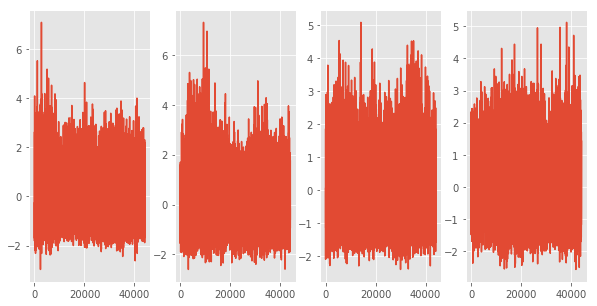

epoch: 9
Discriminator_loss: 1.881964, Generator_loss: 4.424840


In [17]:
myGan.train(epochs = 10, batch = 32, save_interval = 2)

### Discriminator and Generator Loss over Epochs

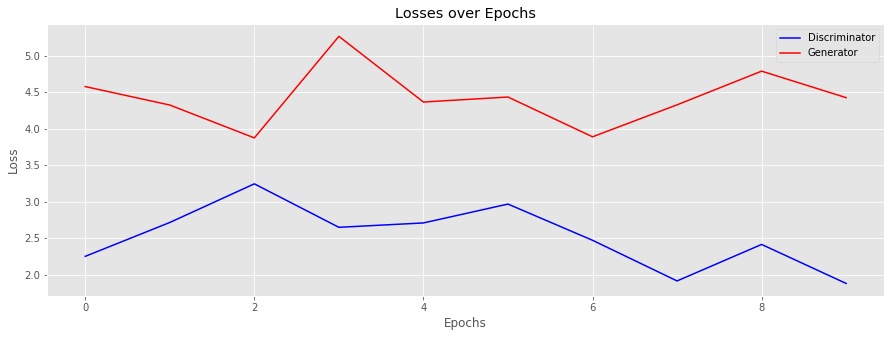

In [22]:
plt.title('Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(myGan.D_loss_hist, '-', label='Discriminator', color='blue')
plt.plot(myGan.G_loss_hist, '-', label='Generator', color='red')
plt.legend(loc='best')

plt.gcf().set_size_inches(15, 5)
plt.show()

### Test Sample

Mean:  [-0.09308296]
Std:  [0.87800574]
Data Normalized...
Generated Audio


Generated Audio Normalized


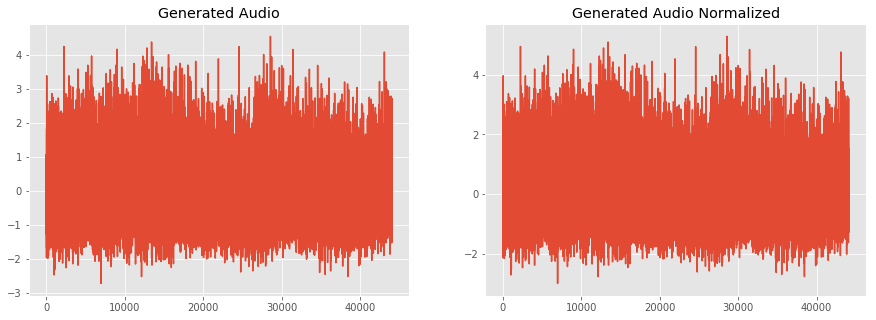

In [28]:
fig2 = plt.figure(figsize=(1, 2))
genT_plt      = fig2.add_subplot(1, 2, 1)
genTN_plt = fig2.add_subplot(1, 2, 2)

genT_plt.set_title('Generated Audio')
genTN_plt.set_title('Generated Audio Normalized')

gen_noise = np.random.normal(0, 1, (1,NOISE_DIM))
gen_test = myGan.G.predict(gen_noise).flatten()
gen_test_norm = normalization(gen_test)

print("Generated Audio")
IPython.display.display(ipd.Audio(data=gen_test, rate=SAMPLE_RATE))
print("Generated Audio Normalized")
IPython.display.display(ipd.Audio(data=gen_test_norm, rate=SAMPLE_RATE))

genT_plt.plot(gen_test, '-', )
genTN_plt.plot(gen_test_norm, '-', )

plt.gcf().set_size_inches(15, 5)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()